# **Vaccine Sentiment Classifier using BERT**
---
## Chalkias Spyridon


# Vaccine Sentiment Classifier
---
This project demonstrates the use of  sentiment  analysis  on  a  dataset  consisting  of tweets in order to infer whether a tweet is:
1.  Neutral
2.  Anti-vax
3.  Pro-vax

by fine-tuning the Hugging Face's pretrained **BERT** model.

## 1. Imports and initializations

#### First of all, import the necessary packages.

In [ ]:
!pip install transformers datasets
!pip install -q "tqdm>=4.36.1"

import os
import random

import warnings
warnings.filterwarnings("ignore")

import transformers
from transformers import BertModel, BertTokenizer, AdamW, Adafactor, get_linear_schedule_with_warmup

import seaborn as sns
from sklearn.metrics import classification_report
from collections import defaultdict

# Progress bar
from tqdm.auto import tqdm
tqdm.pandas()

import torch
import torch.nn.functional as F
from torch.autograd import Variable
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

!pip install --upgrade gensim
import gensim.downloader
from gensim import corpora

# Use an advanced stopword container via NLTK
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

# Import spacy for the lemmatization process
import spacy
from scipy import interp
nlp = spacy.load('en_core_web_sm')

     |████████████████████████████████| 3.8 MB 5.4 MB/s 
     |████████████████████████████████| 311 kB 42.9 MB/s 
     |████████████████████████████████| 6.5 MB 32.6 MB/s 
     |████████████████████████████████| 67 kB 5.1 MB/s 
     |████████████████████████████████| 596 kB 41.0 MB/s 
     |████████████████████████████████| 895 kB 33.9 MB/s 
     |████████████████████████████████| 134 kB 44.4 MB/s 
     |████████████████████████████████| 212 kB 39.1 MB/s 
     |████████████████████████████████| 1.1 MB 38.6 MB/s 
     |████████████████████████████████| 271 kB 10.8 MB/s 
     |████████████████████████████████| 94 kB 415 kB/s 
     |████████████████████████████████| 144 kB 33.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 24.1 MB 1.6 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3

#### Snippet for reproducible results

In [ ]:
def set_seed(seed = 420):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed()

#### Get datasets.

In [ ]:
at = 'https://github.com/spChalk/Vaccine-Sentiment-Classifier/tree/main/data'

# Dataset filenames
training_set_name = 'vs_train.csv' 
validation_set_name = 'vs_dev.csv' 

# Read the dataset and instantiate the corresponding variables
training_set = pd.read_csv(at + training_set_name, index_col=0)
# Validation set. 
val_set = pd.read_csv(at + validation_set_name, index_col=0)

#### Have a look at the datasets.

In [ ]:
training_set

,tweet,label
0,Sip N Shop Come thru right now #Marjais #Popul...,0
1,I don't know about you but My family and I wil...,1
2,@MSignorile Immunizations should be mandatory....,2
3,President Obama spoke in favor of vaccination ...,0
4,"""@myfoxla: Arizona monitoring hundreds for mea...",0
...,...,...
15971,@Salon if u believe the anti-vax nutcases caus...,1
15972,How do you feel about parents who don't #vacci...,0
15973,70 Preschoolers Tested for Measles in Simi Val...,0
15974,Finance Minister: Budget offers room to procur...,0


In [ ]:
val_set

,tweet,label
0,@user They had a massive surge in with covid d...,1
1,Required vaccines for school: Parents and guar...,0
2,“@KCStar: Two more Johnson County children hav...,0
3,NV can do better. Which states are the best (a...,2
4,Nothing like killing ourselves w/ our own fear...,2
...,...,...
2277,RT @abc7: Number of measles cases reported in ...,0
2278,"Evidence points to the idea that ""measles affe...",0
2279,"Where's @SavedYouAClick ""@voxdotcom: Why you s...",2
2280,Some of my favorite people have autism. If tha...,2


## 2. Data Preprocessing

#### Define stopwords set and lemmatizer.

In [ ]:
stop_words = set(stopwords.words())

# Define Lemmatizer
lemmatok = lambda doc: ' '.join([token.lemma_ for token in nlp(doc) if token.lemma_ != '-PRON-' and not token.lemma_ in stop_words])

#### Cleaning utility function

In [ ]:
def clean(data, label):    
    data.dropna(inplace=True)
    data[label] = data[label].str.replace('http\S+|www.\S+', '', case=False)    # Remove URLs from dataset
    data[label] = data[label].str.replace(r'\<.*\>', '')                        # Remove noise contained in '< >' parenthesis
    data[label] = data[label].str.replace('RT ', '', case=False)                # Remove the phrase 'RT' from all strings
    data[label] = data[label].str.replace('@[^\s]+', '', case=False)            # Remove '@' and the following twitter name from strings
    data[label] = data[label].str.replace('[^\w\s]', ' ')                       # Remove any punctuation
    data[label] = data[label].str.replace('\r\n', ' ')                          # Remove '\r\n' which is present in some strings
    data[label] = data[label].str.replace('\d+', '').str.lower().str.strip()    # Remove numbers, capitalisation and white space
    data[label] = data[label].progress_map(lambda x: lemmatok(x))               # Lemmatize the data

In [ ]:
clean(training_set, 'tweet')
clean(val_set, 'tweet')

  0%|          | 0/15976 [00:00<?, ?it/s]

  0%|          | 0/2282 [00:00<?, ?it/s]

#### Have a look at the clean datasets.

In [ ]:
training_set

,tweet,label
0,sip shop thru right marjais popularnobodie...,0
1,know family covid vaccine anytime soon,1
2,immunization mandatory period oklahoma w...,2
3,president obama speak favor vaccination child ...,0
4,arizona monitor hundred measle link disneyland...,0
...,...,...
15971,believe anti vax nutcase cause measle ignore o...,1
15972,feel parent vaccinate kid measlesoutbreak,0
15973,preschooler test measle simi valley,0
15974,finance minister budget offer room procure c...,0


In [ ]:
val_set

,tweet,label
0,massive surge covid death immediately vaccine ...,1
1,require vaccine school parent guardian child...,0
2,two johnson county child measle,0
3,nv well state good bad vaccinate kid,2
4,nothing like kill w fear mt vaccine fear fue...,2
...,...,...
2277,number measle case report cali year high ...,0
2278,evidence point idea measle affect immune sys...,0
2279,vaccinate kid two minute,2
2280,favorite people autism reason bring back dis...,2


#### Define a tokenizer, in order to view the average sequence length of data.

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
def print_token_counts(tokenizer, data):
    token_lens = []
    for tweet in  tqdm(data):
        tokens = tokenizer.encode(tweet, max_length=512, truncation=True)
        token_lens.append(len(tokens))

    sns.distplot(token_lens)
    plt.xlim([0, 100]);
    plt.xlabel('Token count');

  0%|          | 0/15976 [00:00<?, ?it/s]

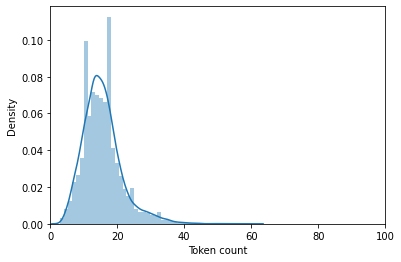

In [ ]:
print_token_counts(tokenizer, training_set['tweet'])

  0%|          | 0/2282 [00:00<?, ?it/s]

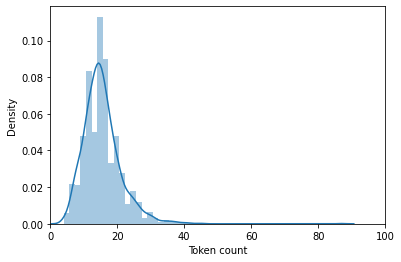

In [ ]:
print_token_counts(tokenizer, val_set['tweet'])

As we can see, most of the tweets contain less than 100 tokens.

## 3. Class & utility function definitions.

In [ ]:
'''
    Loss vs Epochs plotting function
'''
def loss_vs_epochs_loss(train_losses, valid_losses):
    num_epochs = len(train_losses)
    plt.plot([i+1 for i in range(num_epochs)], train_losses, label = "Training loss")
    plt.plot([i+1 for i in range(num_epochs)], valid_losses, label = "Validation loss")
    plt.legend()
    plt.xlabel('Number of epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs Epochs Plot')
    plt.show()

In [ ]:
'''
    Dataset for the tweets.
    Applies encoding to all of the tweets and returns a dictionary
        containing:
    - The initial tweet.
    - The input ids.
    - The attention mask.
    - The targets.
'''
class TweetDataset(Dataset):
    def __init__(self, tweets, targets, tokenizer, max_len):
        self.tweets =       tweets
        self.targets =      targets
        self.tokenizer =    tokenizer
        self.max_len =      max_len

    def __len__(self):
        return len(self.tweets)
  
    def __getitem__(self, item):
        tweet =     str(self.tweets[item])
        target =    self.targets[item]
        encoding =  self.tokenizer.encode_plus(tweet,
                                            add_special_tokens=True,
                                            max_length=self.max_len,
                                            truncation=True,
                                            return_token_type_ids=False,
                                            pad_to_max_length=True,
                                            return_attention_mask=True,
                                            return_tensors='pt'
                                            )
    
        return {'tweet': tweet,
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'targets': torch.tensor(target, dtype=torch.long)
                }

In [ ]:
def create_tweet_dataset(df, tokenizer, max_len):
    return TweetDataset(
            tweets=df.tweet.to_numpy(),
            targets=df.label.to_numpy(),
            tokenizer=tokenizer,
            max_len=max_len
        )

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    dataset = create_tweet_dataset(df, tokenizer, max_len)
    
    return DataLoader(dataset, batch_size=batch_size)

In [ ]:
'''
    The main model is being represented by class VSC 
    (meaning Vaccine Sentiment Classifier). 
    
    The class contains:
    - A pretrained BERT model
    - A dropout layer
    - A linear layer 
    - A Softmax layer
'''
class VSC(nn.Module):
    def __init__(self, n_classes, dropout=.3, pretrained_model_name='bert-base-uncased'):
        super(VSC, self).__init__()
        self.bert = BertModel.from_pretrained(pretrained_model_name, return_dict=False)
        self.dropout = nn.Dropout(p=dropout)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_ids, attention_mask):    
        _, output = self.bert( input_ids=input_ids,
                                attention_mask=attention_mask)
        
        output = self.dropout(output)
        output = self.out(output)
        return self.softmax(output)

In [ ]:
'''
    A custom Trainer class has been implemented, in order to fine-tune 
    the BERT model. The class accepts a configuration dictionary and 
    commences the training according to it. 
'''
class Trainer():
    def __init__(self, config=None):
        if not config is None:
            self.read_config(config)
        else:
            self.read_config({
                'num_epochs': 10,
                'batch_size': 64,
                'dropout': 0.3,
                'max_sequence_len': 60,
                'optimizer': AdamW,
                'learning_rate': 1e-5,
                'warmup_steps': 200,
                'tokenizer': BertTokenizer.from_pretrained('bert-base-uncased'),
                'target_names': {'Neutral':0, 'Anti-Vax':1, 'Pro-Vax':2}
            })

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        print('Training with:')
        print('--------------')
        print(f'Batch size: {self.batch_size}')
        print(f'Number of epochs: {self.num_epochs} ')        
        print(f'Max sequence length: {self.max_len}')        
        print(f'Dropout: {self.dropout}')         
        print(f'Optimizer: {str(self.optim_f)}')        
        print(f'Learning Rate: {self.lr}')        
        print(f'Warmup steps: {self.warmup_steps}')
        print()

    def read_config(self, config):
        self.batch_size = config['batch_size']
        self.num_epochs = config['num_epochs']
        self.target_names = config['target_names']
        self.tokenizer = config['tokenizer']
        self.max_len = config['max_sequence_len']
        self.dropout = config['dropout']
        self.lr = config['learning_rate']
        self.warmup_steps = config['warmup_steps']
        self.optim_f = config['optimizer']

    def fit(self, training_set, val_set):
        self.train_data_loader = create_data_loader(training_set, self.tokenizer, self.max_len, self.batch_size)
        self.val_data_loader = create_data_loader(val_set, self.tokenizer, self.max_len, self.batch_size)

        self.model = VSC(len(self.target_names), self.dropout)
        self.model = self.model.to(self.device)

        self.optimizer = self.optim_f(self.model.parameters(), lr=self.lr, correct_bias=False)
        self.history = defaultdict(list)

        total_steps = len(self.train_data_loader) * self.num_epochs
        
        if not self.lr is None:
            self.scheduler = get_linear_schedule_with_warmup(
                                        self.optimizer,
                                        num_warmup_steps=self.warmup_steps,
                                        num_training_steps=total_steps
                                        )
        self.loss_fn = nn.CrossEntropyLoss().to(self.device)

    # Train epoch process
    def train(self):
        model = self.model.train()
        losses = []
        
        for data in tqdm(self.train_data_loader):
            input_ids = data["input_ids"].to(self.device)
            attention_mask = data["attention_mask"].to(self.device)
            targets = data["targets"].to(self.device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            
            loss = self.loss_fn(outputs, targets)
            losses.append(loss.item())
            
            loss.backward()
            # Perform gradient clipping
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            self.optimizer.step()
            if not self.lr is None:
                self.scheduler.step()
            self.optimizer.zero_grad()

        return np.mean(losses)
    
    # Validation process
    def evaluate(self):
        model = self.model.eval()
        losses = []
        
        with torch.no_grad():
            for data in self.val_data_loader:
                input_ids = data["input_ids"].to(self.device)
                attention_mask = data["attention_mask"].to(self.device)
                targets = data["targets"].to(self.device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            
            loss = self.loss_fn(outputs, targets)
            losses.append(loss.item())

        return np.mean(losses)

    # Main training loop
    def run(self):

        for epoch in range(self.num_epochs):
            print(f'Epoch {epoch + 1}/{self.num_epochs}')
            print('-' * 10)
            train_loss = self.train()
            print(f'Train loss      {"%.3f"%train_loss}')
            
            val_loss = self.evaluate()
            print(f'Validation loss {"%.3f"%val_loss}')
            print()
        
            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)

        loss_vs_epochs_loss(self.history['train_loss'], self.history['val_loss'])

    # Utility function in order to classify predictions
    def predict(self):
        model = self.model.eval()
        predictions = []
        true_values = []

        with torch.no_grad():
            for data in self.val_data_loader:
                input_ids = data["input_ids"].to(self.device)
                attention_mask = data["attention_mask"].to(self.device)
                targets = data["targets"].to(self.device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                
                _, preds = torch.max(outputs, dim=1)
                predictions.extend(preds)
                true_values.extend(targets)

        predictions = torch.stack(predictions).cpu()
        true_values = torch.stack(true_values).cpu()

        print(classification_report(true_values, predictions, target_names=self.target_names))

## 4. Experiments section.

### Experiment with scheduler's warmup steps.

Training with:
--------------
Batch size: 32
Number of epochs: 10 
Max sequence length: 100
Dropout: 0.3
Optimizer: <class 'transformers.optimization.AdamW'>
Learning Rate: 1e-05
Warmup steps: 0



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1/10
----------
Train loss      0.866
Validation loss 0.728



  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 2/10
----------
Train loss      0.822
Validation loss 0.763



  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 3/10
----------
Train loss      0.800
Validation loss 0.715



  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 4/10
----------
Train loss      0.787
Validation loss 0.650



  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 5/10
----------
Train loss      0.775
Validation loss 0.651



  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 6/10
----------
Train loss      0.751
Validation loss 0.632



  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 7/10
----------
Train loss      0.737
Validation loss 0.614



  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 8/10
----------
Train loss      0.728
Validation loss 0.557



  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 9/10
----------
Train loss      0.716
Validation loss 0.552



  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 10/10
----------
Train loss      0.713
Validation loss 0.552



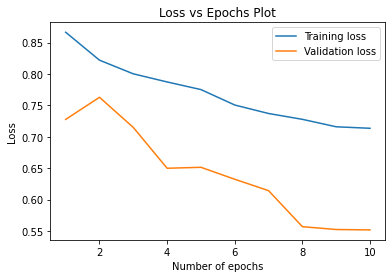

              precision    recall  f1-score   support

     Neutral       0.80      0.80      0.80      1065
    Anti-Vax       0.47      0.38      0.42       296
     Pro-Vax       0.70      0.74      0.72       921

    accuracy                           0.72      2282
   macro avg       0.66      0.64      0.65      2282
weighted avg       0.72      0.72      0.72      2282



In [ ]:
config = {
    'num_epochs': 10,
    'batch_size': 32,
    'dropout': 0.3,
    'max_sequence_len': 100,
    'optimizer': AdamW,
    'learning_rate': 1e-5,
    'warmup_steps': 0,
    'tokenizer': tokenizer,
    'target_names': {'Neutral':0, 'Anti-Vax':1, 'Pro-Vax':2}
}

trainer = Trainer(config)
trainer.fit(training_set, val_set)
trainer.run()
trainer.predict()

Training with:
--------------
Batch size: 32
Number of epochs: 10 
Max sequence length: 100
Dropout: 0.3
Optimizer: <class 'transformers.optimization.AdamW'>
Learning Rate: 1e-05
Warmup steps: 200



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10
----------


  0%|          | 0/500 [00:00<?, ?it/s]

Train loss      0.889
Validation loss 0.650

Epoch 2/10
----------


  0%|          | 0/500 [00:00<?, ?it/s]

Train loss      0.826
Validation loss 0.691

Epoch 3/10
----------


  0%|          | 0/500 [00:00<?, ?it/s]

Train loss      0.793
Validation loss 0.642

Epoch 4/10
----------


  0%|          | 0/500 [00:00<?, ?it/s]

Train loss      0.767
Validation loss 0.560

Epoch 5/10
----------


  0%|          | 0/500 [00:00<?, ?it/s]

Train loss      0.746
Validation loss 0.561

Epoch 6/10
----------


  0%|          | 0/500 [00:00<?, ?it/s]

Train loss      0.732
Validation loss 0.553

Epoch 7/10
----------


  0%|          | 0/500 [00:00<?, ?it/s]

Train loss      0.720
Validation loss 0.570

Epoch 8/10
----------


  0%|          | 0/500 [00:00<?, ?it/s]

Train loss      0.713
Validation loss 0.553

Epoch 9/10
----------


  0%|          | 0/500 [00:00<?, ?it/s]

Train loss      0.706
Validation loss 0.552

Epoch 10/10
----------


  0%|          | 0/500 [00:00<?, ?it/s]

Train loss      0.702
Validation loss 0.552



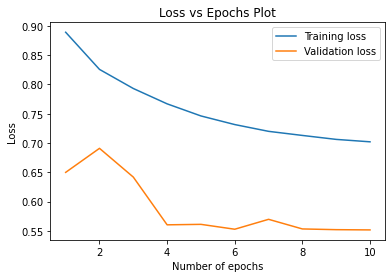

              precision    recall  f1-score   support

     Neutral       0.82      0.79      0.80      1065
    Anti-Vax       0.52      0.40      0.45       296
     Pro-Vax       0.70      0.78      0.74       921

    accuracy                           0.73      2282
   macro avg       0.68      0.66      0.66      2282
weighted avg       0.73      0.73      0.73      2282



In [ ]:
config = {
    'num_epochs': 10,
    'batch_size': 32,
    'dropout': 0.3,
    'max_sequence_len': 100,
    'optimizer': AdamW,
    'learning_rate': 1e-5,
    'warmup_steps': 200,
    'tokenizer': tokenizer,
    'target_names': {'Neutral':0, 'Anti-Vax':1, 'Pro-Vax':2}
}

trainer = Trainer(config)
trainer.fit(training_set, val_set)
trainer.run()
trainer.predict()

Training with:
--------------
Batch size: 32
Number of epochs: 10 
Max sequence length: 100
Dropout: 0.3
Optimizer: <class 'transformers.optimization.AdamW'>
Learning Rate: 1e-05
Warmup steps: 500



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10
----------


  0%|          | 0/500 [00:00<?, ?it/s]

Train loss      0.918
Validation loss 0.700

Epoch 2/10
----------


  0%|          | 0/500 [00:00<?, ?it/s]

Train loss      0.838
Validation loss 0.693

Epoch 3/10
----------


  0%|          | 0/500 [00:00<?, ?it/s]

Train loss      0.808
Validation loss 0.643

Epoch 4/10
----------


  0%|          | 0/500 [00:00<?, ?it/s]

Train loss      0.777
Validation loss 0.665

Epoch 5/10
----------


  0%|          | 0/500 [00:00<?, ?it/s]

Train loss      0.756
Validation loss 0.560

Epoch 6/10
----------


  0%|          | 0/500 [00:00<?, ?it/s]

Train loss      0.738
Validation loss 0.614

Epoch 7/10
----------


  0%|          | 0/500 [00:00<?, ?it/s]

Train loss      0.725
Validation loss 0.655

Epoch 8/10
----------


  0%|          | 0/500 [00:00<?, ?it/s]

Train loss      0.715
Validation loss 0.656

Epoch 9/10
----------


  0%|          | 0/500 [00:00<?, ?it/s]

Train loss      0.709
Validation loss 0.642

Epoch 10/10
----------


  0%|          | 0/500 [00:00<?, ?it/s]

Train loss      0.704
Validation loss 0.560



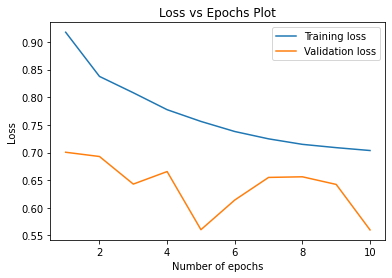

              precision    recall  f1-score   support

     Neutral       0.80      0.80      0.80      1065
    Anti-Vax       0.53      0.43      0.47       296
     Pro-Vax       0.70      0.74      0.72       921

    accuracy                           0.73      2282
   macro avg       0.68      0.66      0.66      2282
weighted avg       0.72      0.73      0.73      2282



In [ ]:
config = {
    'num_epochs': 10,
    'batch_size': 32,
    'dropout': 0.3,
    'max_sequence_len': 100,
    'optimizer': AdamW,
    'learning_rate': 1e-5,
    'warmup_steps': 500,
    'tokenizer': tokenizer,
    'target_names': {'Neutral':0, 'Anti-Vax':1, 'Pro-Vax':2}
}

trainer = Trainer(config)
trainer.fit(training_set, val_set)
trainer.run()
trainer.predict()

### Try to increase the batch size.

Training with:
--------------
Batch size: 64
Number of epochs: 10 
Max sequence length: 100
Dropout: 0.3
Optimizer: <class 'transformers.optimization.AdamW'>
Learning Rate: 1e-05
Warmup steps: 200



Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.914
Validation loss 0.845

Epoch 2/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.835
Validation loss 0.849

Epoch 3/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.807
Validation loss 0.800

Epoch 4/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.780
Validation loss 0.774

Epoch 5/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.761
Validation loss 0.843

Epoch 6/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.742
Validation loss 0.760

Epoch 7/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.736
Validation loss 0.733

Epoch 8/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.724
Validation loss 0.726

Epoch 9/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.715
Validation loss 0.715

Epoch 10/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.711
Validation loss 0.720



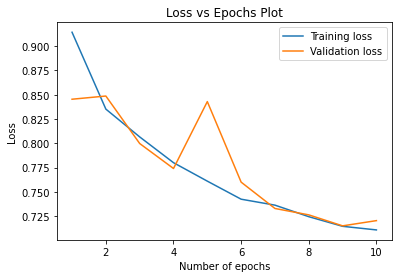

              precision    recall  f1-score   support

     Neutral       0.82      0.77      0.80      1065
    Anti-Vax       0.53      0.42      0.47       296
     Pro-Vax       0.69      0.79      0.74       921

    accuracy                           0.73      2282
   macro avg       0.68      0.66      0.67      2282
weighted avg       0.73      0.73      0.73      2282



In [ ]:
config = {
    'num_epochs': 10,
    'batch_size': 64,
    'dropout': 0.3,
    'max_sequence_len': 100,
    'optimizer': AdamW,
    'learning_rate': 1e-5,
    'warmup_steps': 200,
    'tokenizer': tokenizer,
    'target_names': {'Neutral':0, 'Anti-Vax':1, 'Pro-Vax':2}
}

trainer = Trainer(config)
trainer.fit(training_set, val_set)
trainer.run()
trainer.predict()

### Try to decrease max sequence length.

Training with:
--------------
Batch size: 64
Number of epochs: 10 
Max sequence length: 60
Dropout: 0.3
Optimizer: <class 'transformers.optimization.AdamW'>
Learning Rate: 1e-05
Warmup steps: 200



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.912
Validation loss 0.777

Epoch 2/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.822
Validation loss 0.748

Epoch 3/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.788
Validation loss 0.725

Epoch 4/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.763
Validation loss 0.725

Epoch 5/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.745
Validation loss 0.727

Epoch 6/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.733
Validation loss 0.751

Epoch 7/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.722
Validation loss 0.729

Epoch 8/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.714
Validation loss 0.743

Epoch 9/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.708
Validation loss 0.758

Epoch 10/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.705
Validation loss 0.750



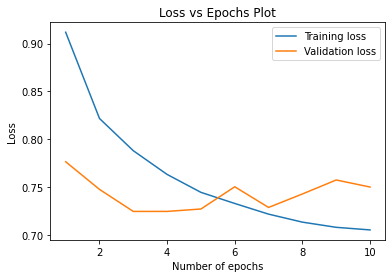

              precision    recall  f1-score   support

     Neutral       0.81      0.79      0.80      1065
    Anti-Vax       0.56      0.47      0.51       296
     Pro-Vax       0.71      0.77      0.74       921

    accuracy                           0.74      2282
   macro avg       0.69      0.68      0.68      2282
weighted avg       0.74      0.74      0.74      2282



In [ ]:
config = {
    'num_epochs': 10,
    'batch_size': 64,
    'dropout': 0.3,
    'max_sequence_len': 60,
    'optimizer': AdamW,
    'learning_rate': 1e-5,
    'warmup_steps': 200,
    'tokenizer': tokenizer,
    'target_names': {'Neutral':0, 'Anti-Vax':1, 'Pro-Vax':2}
}

trainer = Trainer(config)
trainer.fit(training_set, val_set)
trainer.run()
trainer.predict()

Training with:
--------------
Batch size: 64
Number of epochs: 10 
Max sequence length: 30
Dropout: 0.3
Optimizer: <class 'transformers.optimization.AdamW'>
Learning Rate: 1e-05
Warmup steps: 200



Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.913
Validation loss 0.831

Epoch 2/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.835
Validation loss 0.842

Epoch 3/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.804
Validation loss 0.752

Epoch 4/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.776
Validation loss 0.759

Epoch 5/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.753
Validation loss 0.731

Epoch 6/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.741
Validation loss 0.736

Epoch 7/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.733
Validation loss 0.707

Epoch 8/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.722
Validation loss 0.718

Epoch 9/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.713
Validation loss 0.717

Epoch 10/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.710
Validation loss 0.721



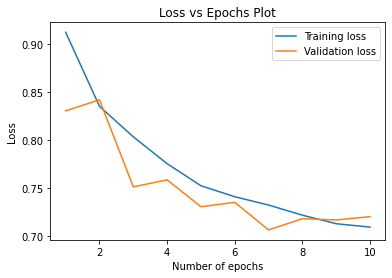

              precision    recall  f1-score   support

     Neutral       0.82      0.78      0.80      1065
    Anti-Vax       0.53      0.41      0.46       296
     Pro-Vax       0.69      0.78      0.73       921

    accuracy                           0.73      2282
   macro avg       0.68      0.66      0.66      2282
weighted avg       0.73      0.73      0.73      2282



In [ ]:
config = {
    'num_epochs': 10,
    'batch_size': 64,
    'dropout': 0.3,
    'max_sequence_len': 30,
    'optimizer': AdamW,
    'learning_rate': 1e-5,
    'warmup_steps': 200,
    'tokenizer': tokenizer,
    'target_names': {'Neutral':0, 'Anti-Vax':1, 'Pro-Vax':2}
}

trainer = Trainer(config)
trainer.fit(training_set, val_set)
trainer.run()
trainer.predict()

### What if we tweaked dropout?

Training with:
--------------
Batch size: 64
Number of epochs: 10 
Max sequence length: 60
Dropout: 0.5
Optimizer: <class 'transformers.optimization.AdamW'>
Learning Rate: 1e-05
Warmup steps: 200



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.917
Validation loss 0.838

Epoch 2/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.822
Validation loss 0.785

Epoch 3/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.791
Validation loss 0.756

Epoch 4/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.768
Validation loss 0.739

Epoch 5/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.747
Validation loss 0.721

Epoch 6/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.737
Validation loss 0.738

Epoch 7/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.726
Validation loss 0.765

Epoch 8/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.718
Validation loss 0.771

Epoch 9/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.712
Validation loss 0.766

Epoch 10/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.710
Validation loss 0.764



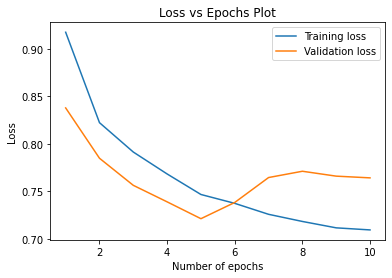

              precision    recall  f1-score   support

     Neutral       0.81      0.79      0.80      1065
    Anti-Vax       0.57      0.44      0.50       296
     Pro-Vax       0.69      0.76      0.72       921

    accuracy                           0.73      2282
   macro avg       0.69      0.66      0.67      2282
weighted avg       0.73      0.73      0.73      2282



In [ ]:
config = {
    'num_epochs': 10,
    'batch_size': 64,
    'dropout': 0.5,
    'max_sequence_len': 60,
    'optimizer': AdamW,
    'learning_rate': 1e-5,
    'warmup_steps': 200,
    'tokenizer': tokenizer,
    'target_names': {'Neutral':0, 'Anti-Vax':1, 'Pro-Vax':2}
}

trainer = Trainer(config)
trainer.fit(training_set, val_set)
trainer.run()
trainer.predict()

Training with:
--------------
Batch size: 64
Number of epochs: 10 
Max sequence length: 60
Dropout: 0.1
Optimizer: <class 'transformers.optimization.AdamW'>
Learning Rate: 1e-05
Warmup steps: 200



Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.912
Validation loss 0.818

Epoch 2/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.836
Validation loss 0.827

Epoch 3/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.809
Validation loss 0.783

Epoch 4/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.784
Validation loss 0.768

Epoch 5/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.760
Validation loss 0.707

Epoch 6/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.744
Validation loss 0.672

Epoch 7/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.733
Validation loss 0.666

Epoch 8/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.723
Validation loss 0.697

Epoch 9/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.717
Validation loss 0.682

Epoch 10/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.712
Validation loss 0.694



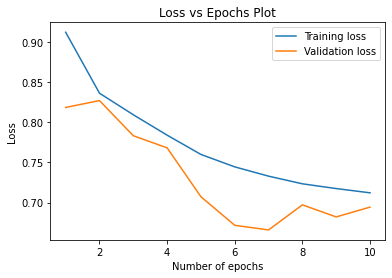

              precision    recall  f1-score   support

     Neutral       0.82      0.77      0.80      1065
    Anti-Vax       0.56      0.42      0.48       296
     Pro-Vax       0.68      0.78      0.73       921

    accuracy                           0.73      2282
   macro avg       0.69      0.66      0.67      2282
weighted avg       0.73      0.73      0.73      2282



In [ ]:
config = {
    'num_epochs': 10,
    'batch_size': 64,
    'dropout': 0.1,
    'max_sequence_len': 60,
    'optimizer': AdamW,
    'learning_rate': 1e-5,
    'warmup_steps': 200,
    'tokenizer': tokenizer,
    'target_names': {'Neutral':0, 'Anti-Vax':1, 'Pro-Vax':2}
}

trainer = Trainer(config)
trainer.fit(training_set, val_set)
trainer.run()
trainer.predict()

### Time to play with the optimizers.

Training with:
--------------
Batch size: 64
Number of epochs: 10 
Max sequence length: 60
Dropout: 0.3
Optimizer: <class 'torch.optim.adam.Adam'>
Learning Rate: 1e-05
Warmup steps: 200



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.968
Validation loss 0.842

Epoch 2/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.848
Validation loss 0.827

Epoch 3/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.828
Validation loss 0.806

Epoch 4/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.805
Validation loss 0.790

Epoch 5/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.787
Validation loss 0.772

Epoch 6/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.768
Validation loss 0.748

Epoch 7/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.757
Validation loss 0.744

Epoch 8/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.747
Validation loss 0.750

Epoch 9/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.739
Validation loss 0.748

Epoch 10/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.734
Validation loss 0.772



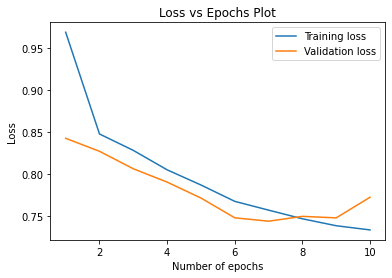

              precision    recall  f1-score   support

     Neutral       0.81      0.79      0.80      1065
    Anti-Vax       0.52      0.42      0.46       296
     Pro-Vax       0.69      0.76      0.72       921

    accuracy                           0.73      2282
   macro avg       0.67      0.65      0.66      2282
weighted avg       0.72      0.73      0.72      2282



In [ ]:
config = {
    'num_epochs': 10,
    'batch_size': 64,
    'dropout': 0.3,
    'max_sequence_len': 60,
    'optimizer': torch.optim.Adam,
    'learning_rate': 1e-5,
    'warmup_steps': 200,
    'tokenizer': tokenizer,
    'target_names': {'Neutral':0, 'Anti-Vax':1, 'Pro-Vax':2}
}

trainer = Trainer(config)
trainer.fit(training_set, val_set)
trainer.run()
trainer.predict()

Training with:
--------------
Batch size: 64
Number of epochs: 10 
Max sequence length: 60
Dropout: 0.3
Optimizer: <class 'torch.optim.sgd.SGD'>
Learning Rate: 0.1
Warmup steps: 200



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.935
Validation loss 0.850

Epoch 2/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.879
Validation loss 0.858

Epoch 3/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.855
Validation loss 0.852

Epoch 4/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.840
Validation loss 0.889

Epoch 5/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.823
Validation loss 0.877

Epoch 6/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.814
Validation loss 0.859

Epoch 7/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.803
Validation loss 0.863

Epoch 8/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.793
Validation loss 0.878

Epoch 9/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.788
Validation loss 0.872

Epoch 10/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.784
Validation loss 0.847



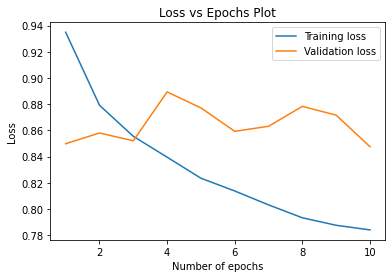

              precision    recall  f1-score   support

     Neutral       0.78      0.81      0.79      1065
    Anti-Vax       0.00      0.00      0.00       296
     Pro-Vax       0.64      0.82      0.72       921

    accuracy                           0.71      2282
   macro avg       0.47      0.54      0.50      2282
weighted avg       0.62      0.71      0.66      2282



In [ ]:
config = {
    'num_epochs': 10,
    'batch_size': 64,
    'dropout': 0.3,
    'max_sequence_len': 60,
    'optimizer': torch.optim.SGD,
    'learning_rate': 1e-1,
    'warmup_steps': 200,
    'tokenizer': tokenizer,
    'target_names': {'Neutral':0, 'Anti-Vax':1, 'Pro-Vax':2}
}

trainer = Trainer(config)
trainer.fit(training_set, val_set)
trainer.run()
trainer.predict()

Training with:
--------------
Batch size: 64
Number of epochs: 10 
Max sequence length: 60
Dropout: 0.3
Optimizer: <class 'transformers.optimization.Adafactor'>
Learning Rate: None
Warmup steps: 200



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.997
Validation loss 0.884

Epoch 2/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.862
Validation loss 0.835

Epoch 3/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.833
Validation loss 0.828

Epoch 4/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.808
Validation loss 0.709

Epoch 5/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.777
Validation loss 0.713

Epoch 6/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.770
Validation loss 0.664

Epoch 7/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.762
Validation loss 0.702

Epoch 8/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.769
Validation loss 0.743

Epoch 9/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.767
Validation loss 0.743

Epoch 10/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.756
Validation loss 0.789



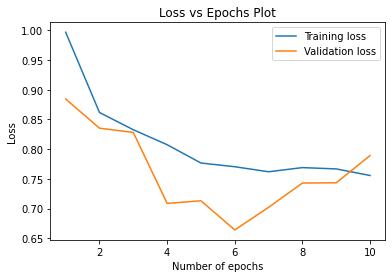

              precision    recall  f1-score   support

     Neutral       0.83      0.76      0.79      1065
    Anti-Vax       0.51      0.38      0.44       296
     Pro-Vax       0.67      0.78      0.72       921

    accuracy                           0.72      2282
   macro avg       0.67      0.64      0.65      2282
weighted avg       0.72      0.72      0.72      2282



In [ ]:
config = {
    'num_epochs': 10,
    'batch_size': 64,
    'dropout': 0.3,
    'max_sequence_len': 60,
    'optimizer': Adafactor,
    'learning_rate': None,
    'warmup_steps': 200,
    'tokenizer': tokenizer,
    'target_names': {'Neutral':0, 'Anti-Vax':1, 'Pro-Vax':2}
}

trainer = Trainer(config)
trainer.fit(training_set, val_set)
trainer.run()
trainer.predict()

### Let's try to rapidly increase and decrease the batch size.

Training with:
--------------
Batch size: 128
Number of epochs: 10 
Max sequence length: 60
Dropout: 0.3
Optimizer: <class 'transformers.optimization.AdamW'>
Learning Rate: 1e-05
Warmup steps: 200



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10
----------


  0%|          | 0/125 [00:00<?, ?it/s]

Train loss      0.956
Validation loss 0.903

Epoch 2/10
----------


  0%|          | 0/125 [00:00<?, ?it/s]

Train loss      0.849
Validation loss 0.928

Epoch 3/10
----------


  0%|          | 0/125 [00:00<?, ?it/s]

Train loss      0.827
Validation loss 0.897

Epoch 4/10
----------


  0%|          | 0/125 [00:00<?, ?it/s]

Train loss      0.813
Validation loss 0.877

Epoch 5/10
----------


  0%|          | 0/125 [00:00<?, ?it/s]

Train loss      0.795
Validation loss 0.877

Epoch 6/10
----------


  0%|          | 0/125 [00:00<?, ?it/s]

Train loss      0.783
Validation loss 0.874

Epoch 7/10
----------


  0%|          | 0/125 [00:00<?, ?it/s]

Train loss      0.777
Validation loss 0.881

Epoch 8/10
----------


  0%|          | 0/125 [00:00<?, ?it/s]

Train loss      0.770
Validation loss 0.880

Epoch 9/10
----------


  0%|          | 0/125 [00:00<?, ?it/s]

Train loss      0.767
Validation loss 0.885

Epoch 10/10
----------


  0%|          | 0/125 [00:00<?, ?it/s]

Train loss      0.764
Validation loss 0.871



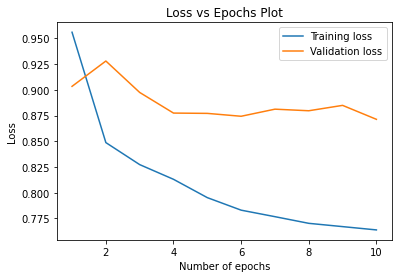

              precision    recall  f1-score   support

     Neutral       0.77      0.80      0.79      1065
    Anti-Vax       0.00      0.00      0.00       296
     Pro-Vax       0.63      0.81      0.71       921

    accuracy                           0.70      2282
   macro avg       0.47      0.54      0.50      2282
weighted avg       0.62      0.70      0.66      2282



In [ ]:
config = {
    'num_epochs': 10,
    'batch_size': 128,
    'dropout': 0.3,
    'max_sequence_len': 60,
    'optimizer': AdamW,
    'learning_rate': 1e-5,
    'warmup_steps': 200,
    'tokenizer': tokenizer,
    'target_names': {'Neutral':0, 'Anti-Vax':1, 'Pro-Vax':2}
}

trainer = Trainer(config)
trainer.fit(training_set, val_set)
trainer.run()
trainer.predict()

Training with:
--------------
Batch size: 8
Number of epochs: 10 
Max sequence length: 60
Dropout: 0.3
Optimizer: <class 'transformers.optimization.AdamW'>
Learning Rate: 1e-05
Warmup steps: 200



Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10
----------


  0%|          | 0/1997 [00:00<?, ?it/s]

Train loss      0.874
Validation loss 0.555

Epoch 2/10
----------


  0%|          | 0/1997 [00:00<?, ?it/s]

Train loss      0.816
Validation loss 0.553

Epoch 3/10
----------


  0%|          | 0/1997 [00:00<?, ?it/s]

Train loss      0.780
Validation loss 0.552

Epoch 4/10
----------


  0%|          | 0/1997 [00:00<?, ?it/s]

Train loss      0.752
Validation loss 0.551

Epoch 5/10
----------


  0%|          | 0/1997 [00:00<?, ?it/s]

Train loss      0.731
Validation loss 0.551

Epoch 6/10
----------


  0%|          | 0/1997 [00:00<?, ?it/s]

Train loss      0.718
Validation loss 0.551

Epoch 7/10
----------


  0%|          | 0/1997 [00:00<?, ?it/s]

Train loss      0.704
Validation loss 0.551

Epoch 8/10
----------


  0%|          | 0/1997 [00:00<?, ?it/s]

Train loss      0.698
Validation loss 0.551

Epoch 9/10
----------


  0%|          | 0/1997 [00:00<?, ?it/s]

Train loss      0.690
Validation loss 0.551

Epoch 10/10
----------


  0%|          | 0/1997 [00:00<?, ?it/s]

Train loss      0.686
Validation loss 0.551



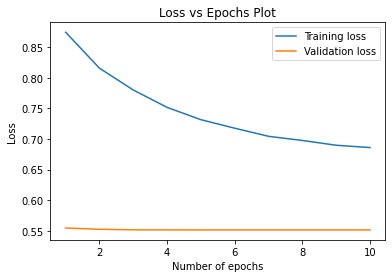

              precision    recall  f1-score   support

     Neutral       0.81      0.79      0.80      1065
    Anti-Vax       0.56      0.44      0.49       296
     Pro-Vax       0.70      0.77      0.73       921

    accuracy                           0.74      2282
   macro avg       0.69      0.67      0.68      2282
weighted avg       0.73      0.74      0.73      2282



In [ ]:
config = {
    'num_epochs': 10,
    'batch_size': 8,
    'dropout': 0.3,
    'max_sequence_len': 60,
    'optimizer': AdamW,
    'learning_rate': 1e-5,
    'warmup_steps': 200,
    'tokenizer': tokenizer,
    'target_names': {'Neutral':0, 'Anti-Vax':1, 'Pro-Vax':2}
}

trainer = Trainer(config)
trainer.fit(training_set, val_set)
trainer.run()
trainer.predict()

### What if we trained our model with a large sequence length?


Training with:
--------------
Batch size: 24
Number of epochs: 5 
Max sequence length: 170
Dropout: 0.3
Optimizer: <class 'transformers.optimization.AdamW'>
Learning Rate: 1e-05
Warmup steps: 200



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/5
----------


  0%|          | 0/666 [00:00<?, ?it/s]

Train loss      0.884
Validation loss 0.578

Epoch 2/5
----------


  0%|          | 0/666 [00:00<?, ?it/s]

Train loss      0.818
Validation loss 0.818

Epoch 3/5
----------


  0%|          | 0/666 [00:00<?, ?it/s]

Train loss      0.781
Validation loss 0.673

Epoch 4/5
----------


  0%|          | 0/666 [00:00<?, ?it/s]

Train loss      0.756
Validation loss 0.619

Epoch 5/5
----------


  0%|          | 0/666 [00:00<?, ?it/s]

Train loss      0.742
Validation loss 0.552



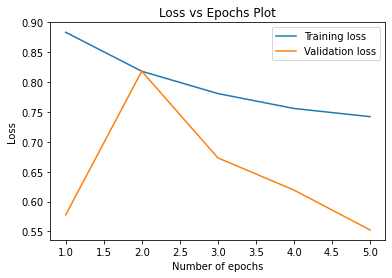

              precision    recall  f1-score   support

     Neutral       0.79      0.79      0.79      1065
    Anti-Vax       0.54      0.38      0.45       296
     Pro-Vax       0.68      0.75      0.71       921

    accuracy                           0.72      2282
   macro avg       0.67      0.64      0.65      2282
weighted avg       0.72      0.72      0.72      2282



In [ ]:
config = {
    'num_epochs': 5,
    'batch_size': 24,
    'dropout': 0.3,
    'max_sequence_len': 170,
    'optimizer': AdamW,
    'learning_rate': 1e-5,
    'warmup_steps': 200,
    'tokenizer': tokenizer,
    'target_names': {'Neutral':0, 'Anti-Vax':1, 'Pro-Vax':2}
}

trainer = Trainer(config)
trainer.fit(training_set, val_set)
trainer.run()
trainer.predict()

### Try to tweak the learning rate a bit.

Training with:
--------------
Batch size: 64
Number of epochs: 5 
Max sequence length: 30
Dropout: 0.3
Optimizer: <class 'transformers.optimization.AdamW'>
Learning Rate: 3e-05
Warmup steps: 200



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/5
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.888
Validation loss 0.843

Epoch 2/5
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.824
Validation loss 0.740

Epoch 3/5
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.781
Validation loss 0.750

Epoch 4/5
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.752
Validation loss 0.708

Epoch 5/5
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.732
Validation loss 0.761



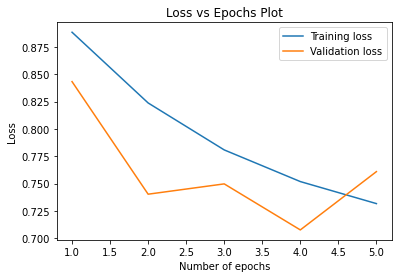

              precision    recall  f1-score   support

     Neutral       0.80      0.80      0.80      1065
    Anti-Vax       0.55      0.37      0.44       296
     Pro-Vax       0.69      0.77      0.73       921

    accuracy                           0.73      2282
   macro avg       0.68      0.65      0.66      2282
weighted avg       0.73      0.73      0.73      2282



In [ ]:
config = {
    'num_epochs': 5,
    'batch_size': 64,
    'dropout': 0.3,
    'max_sequence_len': 30,
    'optimizer': AdamW,
    'learning_rate': 3e-5,
    'warmup_steps': 200,
    'tokenizer': tokenizer,
    'target_names': {'Neutral':0, 'Anti-Vax':1, 'Pro-Vax':2}
}

trainer = Trainer(config)
trainer.fit(training_set, val_set)
trainer.run()
trainer.predict()

Training with:
--------------
Batch size: 64
Number of epochs: 10 
Max sequence length: 60
Dropout: 0.3
Optimizer: <class 'transformers.optimization.AdamW'>
Learning Rate: 3e-05
Warmup steps: 200



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.891
Validation loss 0.834

Epoch 2/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.831
Validation loss 0.831

Epoch 3/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.803
Validation loss 0.806

Epoch 4/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.767
Validation loss 0.754

Epoch 5/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.740
Validation loss 0.700

Epoch 6/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.718
Validation loss 0.739

Epoch 7/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.708
Validation loss 0.719

Epoch 8/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.696
Validation loss 0.735

Epoch 9/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.688
Validation loss 0.729

Epoch 10/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.681
Validation loss 0.727



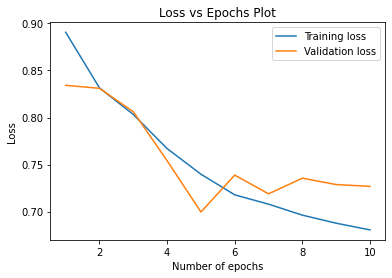

              precision    recall  f1-score   support

     Neutral       0.81      0.79      0.80      1065
    Anti-Vax       0.52      0.47      0.50       296
     Pro-Vax       0.70      0.74      0.72       921

    accuracy                           0.73      2282
   macro avg       0.68      0.67      0.67      2282
weighted avg       0.73      0.73      0.73      2282



In [ ]:
config = {
    'num_epochs': 10,
    'batch_size': 64,
    'dropout': 0.3,
    'max_sequence_len': 60,
    'optimizer': AdamW,
    'learning_rate': 3e-5,
    'warmup_steps': 200,
    'tokenizer': tokenizer,
    'target_names': {'Neutral':0, 'Anti-Vax':1, 'Pro-Vax':2}
}

trainer = Trainer(config)
trainer.fit(training_set, val_set)
trainer.run()
trainer.predict()

## Results
After experimenting with the hyperparameters, the overall best performing model is a pipeline consisting of:

- A pretrained BERT-base-uncased model.
- A dropout layer with 0,3 dropout ratio.
- A linear layer.
- A softmax layer.
- Batch size: 64
- Number of training epochs: 10
- Max sequence length: 60
- Optimizer: AdamW
- Loss function: Cross Entropy Loss
- Learning rate: 1e-05
- Scheduler's warmup steps: 200

The model produces a classification report of:
- Weig.avg precision: 74%
- Weig.avg recall 74%
- Weig.avg f1-score 74%

The generalization gap in the loss vs epochs diagram is pretty good, and the outlook of the losses is pretty normal without any spikes, or unidentified behaviour, indicating that the model neither overfitted or underfitted.

Training with:
--------------
Batch size: 64
Number of epochs: 10 
Max sequence length: 60
Dropout: 0.3
Optimizer: <class 'transformers.optimization.AdamW'>
Learning Rate: 1e-05
Warmup steps: 200



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.912
Validation loss 0.777

Epoch 2/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.822
Validation loss 0.748

Epoch 3/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.788
Validation loss 0.725

Epoch 4/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.763
Validation loss 0.725

Epoch 5/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.745
Validation loss 0.727

Epoch 6/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.733
Validation loss 0.751

Epoch 7/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.722
Validation loss 0.729

Epoch 8/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.714
Validation loss 0.743

Epoch 9/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.708
Validation loss 0.758

Epoch 10/10
----------


  0%|          | 0/250 [00:00<?, ?it/s]

Train loss      0.705
Validation loss 0.750



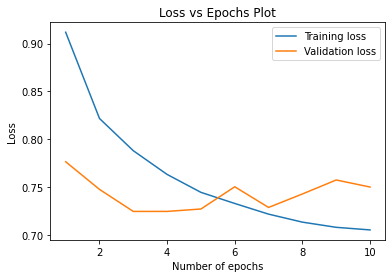

              precision    recall  f1-score   support

     Neutral       0.81      0.79      0.80      1065
    Anti-Vax       0.56      0.47      0.51       296
     Pro-Vax       0.71      0.77      0.74       921

    accuracy                           0.74      2282
   macro avg       0.69      0.68      0.68      2282
weighted avg       0.74      0.74      0.74      2282



In [ ]:
config = {
    'num_epochs': 10,
    'batch_size': 64,
    'dropout': 0.3,
    'max_sequence_len': 60,
    'optimizer': AdamW,
    'learning_rate': 1e-5,
    'warmup_steps': 200,
    'tokenizer': tokenizer,
    'target_names': {'Neutral':0, 'Anti-Vax':1, 'Pro-Vax':2}
}

trainer = Trainer(config)
trainer.fit(training_set, val_set)
trainer.run()
trainer.predict()

*EOF*